# Supervised Pileup Detection

This notebook will contain all the supervised approaches for detecting pileup/backscatters that I used for the APS DNP 2019. These will be perceptron based models, support vector machines, and decision trees and forests. These all use synthetic data, as real data doesn't have a known label!
* side note - for ok performance, run this with a much larger N value on a GPU-accelerated computer

### Data Generation
I need to define my synthetic data generator first

In [1]:
# use these to do the arithmatic
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [2]:
wavelen = 3500 # a single pulse is 3500 4 ns bins long

This is for applying a filter to the data to preprocess it

In [3]:
def trapezoid(rise, top, tau):

    trap = np.empty(3500)
    for i in range(rise):
        trap[i] = tau + i
        trap[i+rise+top] = rise - tau - i
    for i in range(rise, rise+top):
        trap[i] = rise
    for i in range(rise+top, 3500):
        trap[i] = 0
    trap = trap/(rise*tau)
    trap[rise+top:2*rise+top] = -trap[:rise]
    trapNew = np.fft.rfft(trap)
    return trapNew

In [4]:
@nb.jit(nopython=True)
def gen_synth_pulse(amp, T0, noiseAmp, wf):
    length = len(wf)
    cc_slow = 2.5; cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2);cur_s=np.zeros(2);cur_f=np.zeros(2);cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    for i in range(length):
        if i>=T0:
            step[i%2]=1.
        else:
            step[i%2]=0.
        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        r = noiseAmp*(np.random.normal()-.5)
        wf[i]=rc2[i%2] + r;
    return;

Here I will make 2,000 each of pileup and non-pileup

In [5]:
N = 1*10**3

# allocate memory
no_pileup = np.empty((N, 3500))
pileup = np.empty((N, 3500))

# pick from a uniform sample of conditions
amp = np.random.randint(500,5000,2*N)
T0s = np.random.randint(900,1100,2*N)
noiseLvl = 20. # what is the noise level
delays = np.random.randint(50,1000,N)
perc = np.random.random(N)*.8 + .1

build the filter that I will use on the data

In [6]:
trap_filter = trapezoid(5, 0, 1250)

Here I loop through creating the data, and plot the first one before and after shaping to visualize

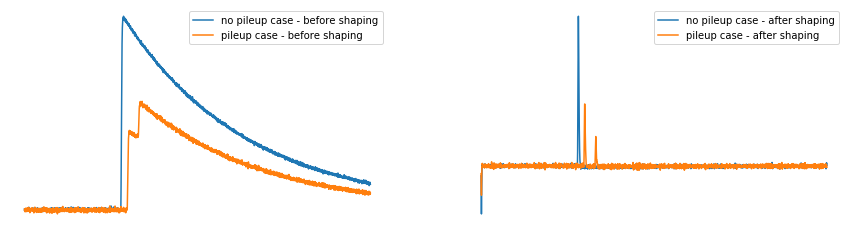

In [7]:
for i in range(N):
    gen_synth_pulse(amp[i], T0s[i], noiseLvl, no_pileup[i])
    
    tmp = np.empty(3500)
    gen_synth_pulse(perc[i]*amp[i+N], T0s[i+N]+delays[i], noiseLvl, tmp)
    gen_synth_pulse((1.-perc[i])*amp[i+N], T0s[i+N], noiseLvl, pileup[i])
    pileup[i] += tmp
    
    if i==0:
        f, ax = plt.subplots(1,2, figsize=(15,4))
        plt.subplot(121)
        plt.plot(no_pileup[0], label='no pileup case - before shaping')
        plt.plot(pileup[0], label='pileup case - before shaping')
        plt.legend()
        plt.axis('off')
        
    no_pileup[i] = np.fft.irfft(np.fft.rfft(no_pileup[i])*trap_filter)
    pileup[i] = np.fft.irfft(np.fft.rfft(pileup[i])*trap_filter)
        
    if i==0:
        plt.subplot(122)
        plt.plot(no_pileup[0], label='no pileup case - after shaping')
        plt.plot(pileup[0], label='pileup case - after shaping')
        plt.legend()
        plt.axis('off')

I need to shuffle the data so that the training sees both types of data

In [8]:
X = np.append(no_pileup, pileup, 0)
y = np.append(np.zeros(N), delays)

In [9]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

I need to keep the same X's paired with the same y's while I shuffle!

In [10]:
shuffle_in_unison(X, y)

I want to normalize all the waveforms to be across the same range to make the training faster

In [11]:
@nb.jit(nopython=True)
def normBatch(data):
    for i in range(len(data)):
        data[i] = data[i] - np.amin(data[i])
        data[i] = data[i]*2./np.amax(data[i])
        data[i] = data[i] - 1

In [12]:
normBatch(X[:10])
normBatch(X)

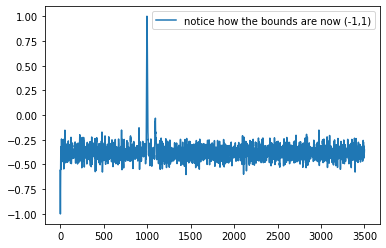

In [13]:
plt.plot(X[0], label='notice how the bounds are now (-1,1)');
plt.legend();

I want to keep track of the histories so that I can plot them later

In [14]:
histories = []

I want to use keras to build my perceptron based models quickly at a high level

In [15]:
from keras import callbacks
from keras.models import Model, load_model
from keras.layers import Input, Conv1D, Flatten, BatchNormalization, Activation, Add, Dense, MaxPooling1D
from keras.optimizers import Adam, SGD
from keras.initializers import glorot_uniform

Using TensorFlow backend.


# Perceptron Based Approaches
These will all use perceptrons, with various other features, such as convolutions, recurrent networks, or residual networks. The output of these is the delay in time between the two pulses (0 for no pileup), and the root mean square of the predictions and truth will be minimized. In implementation a cutoff of some delay will determine whether these are pileup or not, and minimizing the RMS difference will mean a lower cutoff can be used. These all chop off leading and tail ends of the pulse for speed and because those parts of the pulse don't matter. I will try all of the methods, plot their improvement as I train them, and discuss their results afterwards.
## Simple Convolutional Neural Network
This is a simple convolutional neural network with only 3 layers

In [16]:
def cnn(input_shape=(1200,1)):
    X_in = Input(input_shape)
    X = BatchNormalization()(X_in)
    X = Conv1D(256, 7, activation='relu', padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv1D(128, 5, activation='relu', padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv1D(64, 3, activation='relu', padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Flatten()(X)
    X = Dense(1)(X)
    m = Model(inputs=X_in, outputs=X, name="N-layer Conv Net")
    o = Adam()
    m.compile(optimizer=o, loss='mean_squared_error')
    return m

In [17]:
model = cnn()
history = model.fit(X.reshape((-1,3500,1))[:,800:2000,:], y, validation_split=0.33, epochs=10)
histories.append(history)







Train on 2679 samples, validate on 1321 samples
Epoch 1/10
2679/2679 [==============================] - 44s 16ms/step - loss: 51769.3582 - val_loss: 29561.6014
Epoch 2/10
2679/2679 [==============================] - 49s 18ms/step - loss: 33741.6677 - val_loss: 29454.9592
Epoch 3/10
2679/2679 [==============================] - 58s 22ms/step - loss: 31855.0222 - val_loss: 25778.9659
Epoch 4/10
2679/2679 [==============================] - 51s 19ms/step - loss: 29267.6132 - val_loss: 23702.7614
Epoch 5/10
2679/2679 [==============================] - 59s 22ms/step - loss: 27200.4801 - val_loss: 33799.4142
Epoch 6/10
2679/2679 [==============================] - 54s 20ms/step - loss: 28214.0308 - val_loss: 19616.9058
Epoch 7/10
2679/2679 [==============================] - 49s 18ms/step - loss: 20471.8315 - val_loss: 19070.7999
Epoch 8/10
2679/2679 [==============================] - 54s 20ms/step - loss: 23000.8445 - val_loss: 18254.4141
Epoch 9/10
2679/2679 [============================

## Simple Dense Neural Network
This is a simple dense neural network with only 3 layers

### Dense attempt

In [18]:
def dense(input_shape=(1200,1)):
    X_in = Input(input_shape)
    X = BatchNormalization()(X_in)
    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(1)(X)
    m = Model(inputs=X_in, outputs=X, name="N-layer Conv Net")
    o = Adam()
    m.compile(optimizer=o, loss='mean_squared_error')
    return m

In [19]:
model = dense()
history = model.fit(X.reshape((-1,3500,1))[:,800:2000,:], y, validation_split=0.33, epochs=10)
histories.append(history)

Train on 2679 samples, validate on 1321 samples
Epoch 1/10
2679/2679 [==============================] - 2s 847us/step - loss: 78371.9518 - val_loss: 46585.3573
Epoch 2/10
2679/2679 [==============================] - 1s 211us/step - loss: 47755.0972 - val_loss: 39358.3659
Epoch 3/10
2679/2679 [==============================] - 1s 251us/step - loss: 38872.6918 - val_loss: 31258.0788
Epoch 4/10
2679/2679 [==============================] - 1s 312us/step - loss: 34858.8079 - val_loss: 28744.2769
Epoch 5/10
2679/2679 [==============================] - 1s 279us/step - loss: 30369.5905 - val_loss: 28666.9550
Epoch 6/10
2679/2679 [==============================] - 1s 360us/step - loss: 28508.1357 - val_loss: 27401.7941
Epoch 7/10
2679/2679 [==============================] - 1s 386us/step - loss: 25572.4808 - val_loss: 26665.8319
Epoch 8/10
2679/2679 [==============================] - 1s 459us/step - loss: 23236.9247 - val_loss: 22924.1568
Epoch 9/10
2679/2679 [==============================] - 

## LSTM Network -- Recurrent Neural Network
This is a recurrent neural network using LSTMs from keras

In [20]:
from keras.layers import LSTM

In [21]:
def lstm(input_shape=(1200,1)):
    X_in = Input(input_shape)
    X = BatchNormalization()(X_in)
    X = LSTM(32, activation='relu')(X)
    X = Dense(1)(X)
    m = Model(inputs=X_in, outputs=X, name="LSTM")
    o = Adam(clipnorm=1.)
    m.compile(optimizer=o, loss='mean_squared_error')
    return m

In [ ]:
model = lstm()
history = model.fit(X.reshape((-1,3500,1))[:,800:2000,:], y, validation_split=0.33, epochs=10)
histories.append(history)

Train on 2679 samples, validate on 1321 samples
Epoch 1/20
2679/2679 [==============================] - 258s 96ms/step - loss: nan - val_loss: nan
Epoch 2/20
2679/2679 [==============================] - 296s 111ms/step - loss: nan - val_loss: nan
Epoch 3/20
 352/2679 [==>...........................] - ETA: 4:57 - loss: nan

LSTM is not training correctly! This is likely due to the exploding gradient problem, which I try to mitigate with clipnorm. Even with that though, it still happens. The method is really slow anyways, so this cuts this method out

## ResNet 1D
For this, I implemented a one dimensional version of the famous ResNet50

In [20]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [21]:
def convolutional_block(X, f, filters, stage, block, s = 2):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv1D(F1, 1, strides = s, padding='same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv1D(filters = F3, kernel_size = 1, strides = s, padding = 'same', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [22]:
def ResNet50(input_shape=(1200, 1), classes=2):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X = BatchNormalization()(X_input)

    # Stage 1
    X = Conv1D(64, 7, strides=2, name='conv1',padding='same',kernel_initializer=glorot_uniform(seed=0))(X)
    #X = BatchNormalization(axis=2, name='bn_conv1')(X)
    X = Activation('relu')(X)
    #X = MaxPooling1D(3, strides=2)(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')    
    
    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # output layer
    X = Flatten()(X)
    X = Dense(1, activation='relu', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [26]:
model = ResNet50()
history = model.fit(X.reshape((-1,3500,1))[:,800:2000,:], y, validation_split=0.33, epochs=10)
histories.append(history)

Train on 2679 samples, validate on 1321 samples
Epoch 1/10
 256/2679 [=>............................] - ETA: 5:29 - loss: 712676.2676

KeyboardInterrupt: 

## Plotting Performance
This is plotting the validation loss for the different methods

In [24]:
names=['CNN','Dense','ResNet']

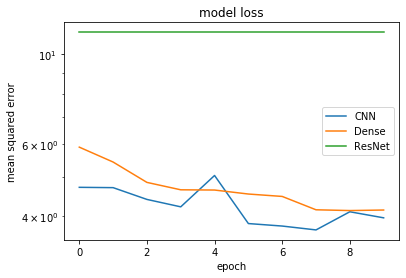

In [25]:
for i, history in enumerate(histories):
    # remember to convert the validation loss into RMS
    plt.plot(np.sqrt(np.array(history.history['val_loss'])/(len(X)/3.)), label=names[i])
    
plt.title('model loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend();
plt.yscale('log')
plt.savefig('plots/training.png')

# Support Vector Machines and Decision Trees
These methods use support vector machines and decision trees or forests. These are very slow, so there performance must be very good for it to be worth it

## Ensemble Decision Tree methods
These methods take a large number of small decision trees or regressors and combine them into one stronger regressor

In [14]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=100).fit(X,y)

In [15]:
hgbr = HistGradientBoostingRegressor().fit(X, y)

In [ ]:
abr = AdaBoostRegressor().fit(X, y)

## Support Vector Machine Methods
These project the data into a much higher dimension space using the kernel trick

In [ ]:
from sklearn.svm import SVR

In [ ]:
svr = SVR(kernel='rbf').fit(X, y)

## Plotting Performance
I need to generate unseen data to test these over

In [ ]:
amp = np.random.randint(500,5000,2*N)
T0s = np.random.randint(900,1100,2*N)
noiseLvl = 20.
delays = np.random.randint(50,1000,N)
perc = np.random.random(N)*.8 + .1

In [ ]:
for i in range(N):
    gen_synth_pulse(amp[i], T0s[i], noiseLvl, no_pileup[i])
    
    tmp = np.empty(3500)
    gen_synth_pulse(perc[i]*amp[i+N], T0s[i+N]+delays[i], noiseLvl, tmp)
    gen_synth_pulse((1.-perc[i])*amp[i+N], T0s[i+N], noiseLvl, pileup[i])
    pileup[i] += tmp
    
    no_pileup[i] = np.fft.irfft(np.fft.rfft(no_pileup[i])*trap_filter)
    pileup[i] = np.fft.irfft(np.fft.rfft(pileup[i])*trap_filter)
    

In [ ]:
X = np.append(no_pileup, pileup, 0)
y = np.append(np.zeros(N), delays)

In [ ]:
shuffle_in_unison(X, y)

In [ ]:
normBatch(X)

print each regressor's score over the validation data

In [ ]:
for regressor in ['rfr','hgbr','abr','svr']:
    print(regressor, (eval(regressor)).score(X,y))

# Results
* Perceptron based methods work very well
* Feature-by-feature methods are both slow and ineffective
* ResNet 50 1D is v good when trained with a ton of data!
* HistGradientBoosted is wayyy faster than the other decision trees, I'll use that later